# Load evaluation results

In [1]:
import pickle
total_val_loss = []
total_val_acc = []
total_loss = []
total_acc = []

selected_idx = []

with open("model_training_results_all.pkl", "rb") as file:
    loaded_data = pickle.load(file)

hyperparameter_combinations = loaded_data['hyperparameter_combinations']
selected_idx = loaded_data["selected_random_idx"]
total_acc = loaded_data["total_acc"]
total_val_acc = loaded_data["total_val_acc"]
total_loss = loaded_data["total_loss"]
total_val_loss = loaded_data["total_val_loss"]

### sort the 10 best parameters

In [2]:
indices_sorted = sorted(range(len(total_val_acc)), key=lambda i: total_val_acc[i], reverse=True)
print("10 best parameters")
for i in range(10):
      print(f"---------- RANK {i+1}:")
      print(f"PARAMETERS: {hyperparameter_combinations[selected_idx[indices_sorted[i]]]}")
      best_val_acc = total_val_acc[indices_sorted[i]]
      best_acc = total_acc[indices_sorted[i]]
      best_loss = total_loss[indices_sorted[i]]
      best_val_loss = total_val_loss[indices_sorted[i]]
      best_parameters = hyperparameter_combinations[indices_sorted[i]]
      print(f"acc: {best_acc}, val_acc: {best_val_acc}, loss: {best_loss}, val_loss: {best_val_loss}")


10 best parameters
---------- RANK 1:
PARAMETERS: (256, 256, 256, 0, 512, 512, 3, 3, 3, 3, 2, 'relu', 0.0001)
acc: 0.891711433728536, val_acc: 0.7281614740689596, loss: 0.3215294082959493, val_loss: 0.6935030817985535
---------- RANK 2:
PARAMETERS: (128, 64, 256, 0, 128, 128, 3, 7, 3, 3, 2, 'relu', 0.0001)
acc: 0.8563702702522278, val_acc: 0.7182386716206869, loss: 0.3962838153044383, val_loss: 0.7078284422556559
---------- RANK 3:
PARAMETERS: (256, 128, 128, 0, 512, 128, 3, 5, 3, 5, 2, 'relu', 0.0001)
acc: 0.8955763975779215, val_acc: 0.7160385251045227, loss: 0.2965907355149587, val_loss: 0.7528843482335409
---------- RANK 4:
PARAMETERS: (128, 128, 128, 128, 256, 256, 3, 3, 3, 3, 2, 'relu', 0.0001)
acc: 0.8116069634755453, val_acc: 0.7160275181134542, loss: 0.4933221439520518, val_loss: 0.6761843959490458
---------- RANK 5:
PARAMETERS: (256, 128, 64, 256, 512, 128, 5, 3, 3, 3, 2, 'relu', 0.0001)
acc: 0.7883970340092977, val_acc: 0.7149420976638794, loss: 0.5334452986717224, val_loss:

## Load data

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = 224
# All images will be rescaled by 1./255 (for data normalization)
# I add new augmented samples using: rotations, zooming, width and height shifts, shearing, etc.
# This doesn't increase the number of original samples but provides varied data during training, helping with generalization.
train_datagen = ImageDataGenerator(
       rescale=1/255,
       rotation_range=10,
       width_shift_range=0.2,
       height_shift_range=0.2,
       shear_range=0.2,
       zoom_range=0.2,
       horizontal_flip=True,
       fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
       './data/train/', 
       target_size=(image_size, image_size),
       batch_size=16,
       class_mode='categorical')

Found 905 images belonging to 5 classes.


In [4]:
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

validation_generator =  test_datagen.flow_from_directory("./data/test/",
                                                        batch_size=16,
                                                        class_mode  = 'categorical',
                                                        target_size = (image_size, image_size))

Found 145 images belonging to 5 classes.


## Create model

In [5]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop


def create_model(n1=16, n2=16, n3=16, n4=0, n5=128, n6=0, s1=3, s2=3, s3=3, s4=3, 
    pooling_size=2, activation='relu', learning_rate=1e-4):

  model = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=(image_size, image_size, 3)), 
      tf.keras.layers.Conv2D(n1, (s1, s1), activation=activation),
      tf.keras.layers.MaxPooling2D(pooling_size, pooling_size),
      tf.keras.layers.Conv2D(n2, (s2, s2), activation=activation),
      tf.keras.layers.MaxPooling2D(pooling_size, pooling_size),
      tf.keras.layers.Conv2D(n3, (s3, s3), activation=activation),
      tf.keras.layers.MaxPooling2D(pooling_size, pooling_size)
  ])

  if n4:
    model.add(tf.keras.layers.Conv2D(n4, (s4, s4), activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pooling_size, pooling_size))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(n5, activation=activation))
  if n6:
    model.add(tf.keras.layers.Dense(n6, activation=activation))
  model.add(tf.keras.layers.Dense(5, activation='softmax'))
      
  


  model.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(learning_rate=learning_rate),
                metrics=['accuracy'])
  return model

## create hyper-parameters grid

In [6]:
# Define the hyperparameter grid
hyperparameter_grid = {
    'n1': [64, 128, 256],
    'n2': [64, 128, 256],
    'n3': [64, 128, 256],
    'n4': [0, 64, 128, 256],
    'n5': [128, 256, 512],
    'n6': [128, 256, 512],
    's1': [3, 5, 7],
    's2': [3, 5, 7],
    's3': [3, 5, 7],
    's4': [3, 5, 7],
    'pooling_size': [2],
    'activation': ['relu', 'tanh'],
    'learning_rate': [1e-4]
}

# Create a list of all hyperparameter names
hyperparameter_names = list(hyperparameter_grid.keys())

## Train model 1

In [7]:
params_1 = (256, 256, 256, 0, 512, 512, 3, 3, 3, 3, 2, 'relu', 0.0001)
best_params_1 = dict(zip(hyperparameter_names, params_1))
best_params_1

{'n1': 256,
 'n2': 256,
 'n3': 256,
 'n4': 0,
 'n5': 512,
 'n6': 512,
 's1': 3,
 's2': 3,
 's3': 3,
 's4': 3,
 'pooling_size': 2,
 'activation': 'relu',
 'learning_rate': 0.0001}

In [8]:
model = create_model(**best_params_1)
        
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 173056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    88,605,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,057,733 (343.54 MB)

 Trainable params: 90,057,733 (343.54 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks_list = [
    ModelCheckpoint(
        filepath='./models/model_1.keras', 
        monitor='val_loss', 
        save_best_only=True),
    EarlyStopping(
        monitor='val_loss', 
        patience=20),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.05, 
        patience=10)
]

In [10]:
history_1 = model.fit(
    train_generator,
    epochs=200,
    validation_data=validation_generator,
    callbacks=callbacks_list,  
    verbose=1
)

Epoch 1/200


d:\hasan\my projects\final weather\weather_classification\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.2728 - loss: 1.5317 - val_accuracy: 0.4621 - val_loss: 1.1302 - learning_rate: 1.0000e-04
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.5521 - loss: 1.0398 - val_accuracy: 0.6069 - val_loss: 0.8491 - learning_rate: 1.0000e-04
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.6359 - loss: 0.8796 - val_accuracy: 0.6069 - val_loss: 0.9218 - learning_rate: 1.0000e-04
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.6291 - loss: 0.8643 - val_accuracy: 0.6759 - val_loss: 0.8066 - learning_rate: 1.0000e-04
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.6405 - loss: 0.8634 - val_accuracy: 0.6759 - val_loss: 0.7952 - learning_rate: 1.0000e-04
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.6503 - loss: 0.8167 - val_accuracy: 0.6000 - val_loss: 0.8092 - learning_rate: 1.0000e-04
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.6767 - los

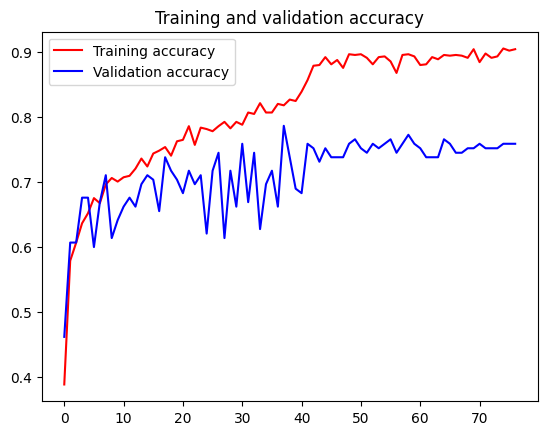

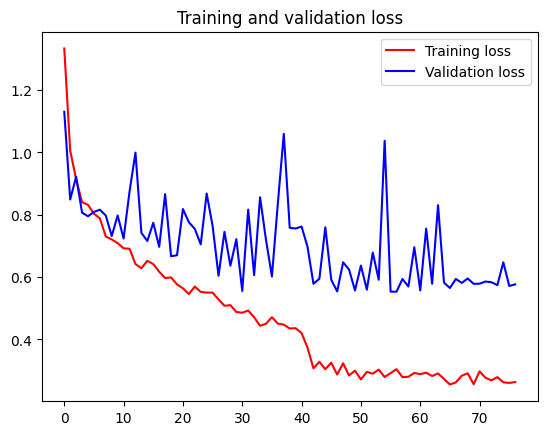

In [11]:
import matplotlib.pyplot as plt
# Plot the results
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']


epochs = range(len(acc))


plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

## Train model 2

In [12]:
params_2 = (256, 256, 256, 256, 512, 512, 5, 5, 5, 5, 2, 'relu', 0.0001)
best_params_2 = dict(zip(hyperparameter_names, params_2))
best_params_2

{'n1': 256,
 'n2': 256,
 'n3': 256,
 'n4': 256,
 'n5': 512,
 'n6': 512,
 's1': 5,
 's2': 5,
 's3': 5,
 's4': 5,
 'pooling_size': 2,
 'activation': 'relu',
 'learning_rate': 0.0001}

In [13]:
model_2 = create_model(**best_params_2)
        
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 220, 220, 256)  │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 110, 110, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 106, 106, 256)  │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 53, 53, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 256)    │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 20, 20, 256)    │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    13,107,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,308,357 (69.84 MB)

 Trainable params: 18,308,357 (69.84 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
callbacks_list = [
    ModelCheckpoint(
        filepath='./models/model_2.keras', 
        monitor='val_loss', 
        save_best_only=True),
    EarlyStopping(
        monitor='val_loss', 
        patience=20),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.05, 
        patience=10)
]

In [15]:
history_2 = model_2.fit(
    train_generator,
    epochs=200,
    validation_data=validation_generator,
    callbacks=callbacks_list,  
    verbose=1
)

Epoch 1/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 223s 4s/step - accuracy: 0.2714 - loss: 1.6257 - val_accuracy: 0.3517 - val_loss: 1.3838 - learning_rate: 1.0000e-04
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 221s 4s/step - accuracy: 0.4617 - loss: 1.2029 - val_accuracy: 0.5931 - val_loss: 0.9486 - learning_rate: 1.0000e-04
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 221s 4s/step - accuracy: 0.5591 - loss: 1.0600 - val_accuracy: 0.4966 - val_loss: 1.1709 - learning_rate: 1.0000e-04
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - accuracy: 0.5755 - loss: 0.9757 - val_accuracy: 0.6000 - val_loss: 0.9257 - learning_rate: 1.0000e-04
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - accuracy: 0.6311 - loss: 0.8806 - val_accuracy: 0.5931 - val_loss: 0.8708 - learning_rate: 1.0000e-04
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 221s 4s/step - accuracy: 0.6004 - loss: 0.8979 - val_accuracy: 0.5862 - val_loss: 0.9114 - learning_rate: 1.0000e-04
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 221s 4s/step - accuracy: 

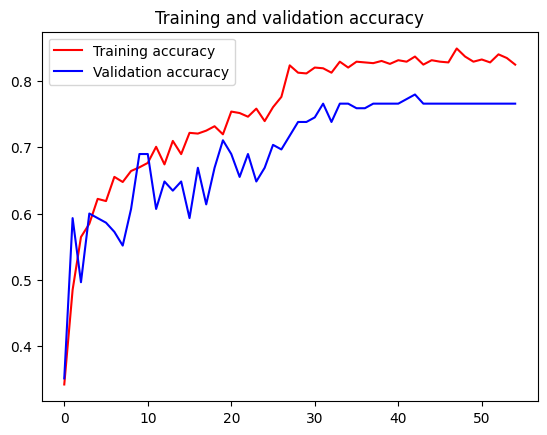

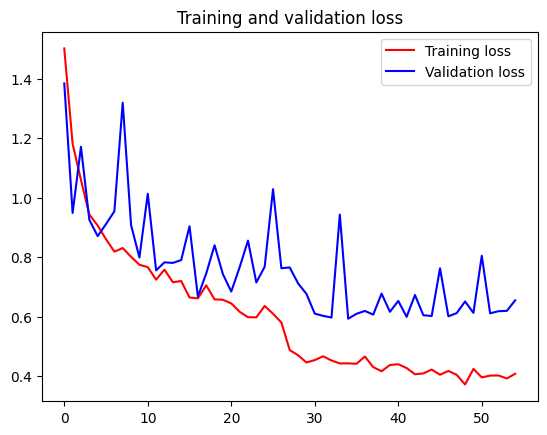

In [16]:
import matplotlib.pyplot as plt
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']


epochs = range(len(acc))


plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

## Train model 3

In [7]:
params_3 = (128, 128, 128, 128, 256, 256, 3, 3, 3, 3, 2, 'relu', 0.0001)
best_params_3 = dict(zip(hyperparameter_names, params_3))
best_params_3

{'n1': 128,
 'n2': 128,
 'n3': 128,
 'n4': 128,
 'n5': 256,
 'n6': 256,
 's1': 3,
 's2': 3,
 's3': 3,
 's4': 3,
 'pooling_size': 2,
 'activation': 'relu',
 'learning_rate': 0.0001}

In [8]:
model_3 = create_model(**best_params_3)
        
model_3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,232,261 (19.96 MB)

 Trainable params: 5,232,261 (19.96 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
callbacks_list = [
    ModelCheckpoint(
        filepath='./models/model_3.keras', 
        monitor='val_loss', 
        save_best_only=True),
    EarlyStopping(
        monitor='val_loss', 
        patience=20),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.05, 
        patience=10)
]

In [12]:
history_3 = model_3.fit(
    train_generator,
    epochs=200,
    validation_data=validation_generator,
    callbacks=callbacks_list,  
    verbose=1
)

Epoch 1/200


d:\hasan\my projects\final weather\weather_classification\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 50s 827ms/step - accuracy: 0.3055 - loss: 1.5020 - val_accuracy: 0.5034 - val_loss: 1.0918 - learning_rate: 1.0000e-04
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 729ms/step - accuracy: 0.5591 - loss: 1.0085 - val_accuracy: 0.5586 - val_loss: 1.0402 - learning_rate: 1.0000e-04
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.5856 - loss: 0.9196 - val_accuracy: 0.6069 - val_loss: 0.9072 - learning_rate: 1.0000e-04
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.6312 - loss: 0.8865 - val_accuracy: 0.5793 - val_loss: 0.8022 - learning_rate: 1.0000e-04
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.6544 - loss: 0.8493 - val_accuracy: 0.6207 - val_loss: 0.8581 - learning_rate: 1.0000e-04
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.6642 - loss: 0.8046 - val_accuracy: 0.6069 - val_loss: 0.8213 - learning_rate: 1.0000e-04
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.6644 - loss

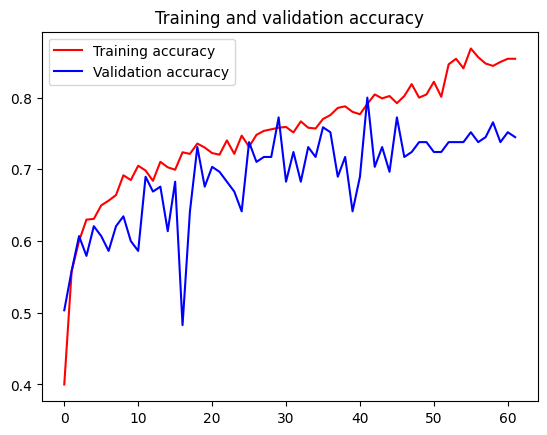

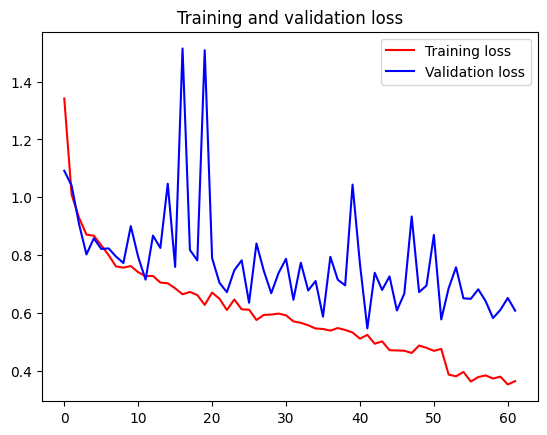

In [13]:
import matplotlib.pyplot as plt
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']


epochs = range(len(acc))


plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)